# Adult Dataset — Projet de Classification

**Objectif :** Prédire si le revenu annuel d'un individu est supérieur à 50 000 $  
**Source :** Barry Becker, base de données du recensement américain 1994  
**Dataset :** 48 842 individus · 14 features · 1 variable cible binaire  
**DOI :** [10.24432/C5XW20](https://doi.org/10.24432/C5XW20)

---
## Sommaire

In [250]:
from pathlib import Path
import os

# Constantes
SEED = 42
FIG_DIR = Path.cwd() / 'figures'

In [251]:
# graine pour la reproductibilité de l'aléatoire
os.environ['PYTHONHASHSEED']        = str(SEED)
os.environ['TF_DETERMINISTIC_OPS']  = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

In [252]:
if FIG_DIR.exists():
    os.makedirs(FIG_DIR)

## 1. Chargement des données

In [207]:
# librairies
from urllib import request
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pprint import pprint

# scikit learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# tensorflow/keras
import tensorflow as tf
import keras

In [3]:
# graines pour la reproductibilité de l'aléatoire
def set_seeds(seed: int = SEED) -> None:
    """
    Fixe toutes les sources d'aléatoire pour garantir la reproductibilité.
    (Python 3.12.10, NumPy 2.4, TensorFlow 2.20, Keras 3.13)

    Paramètres
    ----------
    seed : int
        Valeur de la seed (défaut : 42).

    Notes
    -----
    - Les variables d'environnement PYTHONHASHSEED, TF_DETERMINISTIC_OPS
      et TF_CUDNN_DETERMINISTIC doivent être définies AVANT l'import de
      TensorFlow pour être prises en compte.
    - Le déterminisme complet sur GPU n'est pas garanti pour toutes les
      opérations CUDA, même avec ces réglages.
    """
    # Python
    random.seed(seed)

    # Numpy
    np.random.seed(seed)
    # pour utiliser np.random.Generator.choice ou np.random.Generator.shuffle
    # exemple : set_seeds.rng.choice(...)
    set_seeds.rng = np.random.default_rng(seed)

    # Tensorflow
    tf.random.set_seed(seed)

    # Déterminisme des opérations (coût possible en performance sur GPU)
    try:
        tf.config.experimental.enable_op_determinism()
    except RuntimeError:
        # Lève une RuntimeError si déjà activé ou si le GPU ne le supporte pas
        pass

    # keras.utils.set_random_seed pose Python + NumPy + backend en un appel
    # Redondant avec les appels précédents, mais garantit la cohérence
    # si Keras utilise un backend autre que TF (JAX, PyTorch)
    keras.utils.set_random_seed(seed)

    # stockage de la seed (pour les random_state Scikit-Learn ou XGBoost)
    set_seeds.seed = seed

    return

set_seeds()
print(f"Graine paramétrée : {set_seeds.seed}")

Graine paramétrée : 42


In [4]:
np.random.choice(['1', '2'])

np.str_('1')

In [5]:
sns.set_theme('paper')

In [6]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
adult = fetch_ucirepo(id=2) 

In [7]:
# métadonnées 
pprint(adult.metadata) 

{'abstract': 'Predict whether annual income of an individual exceeds $50K/yr '
             'based on census data. Also known as "Census Income" dataset. ',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'Extraction was done by Barry Becker from the '
                                '1994 Census database.  A set of reasonably '
                                'clean records was extracted using the '
                                'following conditions: ((AAGE>16) && (AGI>100) '
                                '&& (AFNLWGT>1)&& (HRSWK>0))\n'
                                '\n'
                                'Prediction task is to determine whether a '
                               

In [8]:
print(adult.metadata['additional_info']['variable_info']) 

Listing of attributes:

>50K, <=50K.

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: Unite

In [9]:
# description des variable 
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,NaN,NaN,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,NaN,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [10]:
# dataframe globale
df = adult.data.original
print(f'Dataset complet : {df.shape[0]:_} lignes × {df.shape[1]} colonnes')

Dataset complet : 48_842 lignes × 15 colonnes


In [11]:
# Noms des colonnes
cols = adult.data.headers.tolist()
target = ['income']
features = [col for col in cols if col not in target]

In [12]:
# aperçu des 5 premières lignes
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 2. Description et nettoyage des données

### 2.1 Types des variables

In [13]:
# nom et type des variables
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int64
 1   workclass       47879 non-null  str  
 2   fnlwgt          48842 non-null  int64
 3   education       48842 non-null  str  
 4   education-num   48842 non-null  int64
 5   marital-status  48842 non-null  str  
 6   occupation      47876 non-null  str  
 7   relationship    48842 non-null  str  
 8   race            48842 non-null  str  
 9   sex             48842 non-null  str  
 10  capital-gain    48842 non-null  int64
 11  capital-loss    48842 non-null  int64
 12  hours-per-week  48842 non-null  int64
 13  native-country  48568 non-null  str  
 14  income          48842 non-null  str  
dtypes: int64(6), str(9)
memory usage: 5.6 MB


In [14]:
# les colonnes de type entier sont les variables numériques
num_features = list(df.select_dtypes(include='number'))
num_features

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [15]:
df[num_features].head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [16]:
# les colonnes de type str doivent être des variables catégorielles
cat_features = list(df.select_dtypes(exclude='number'))
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income']

In [17]:
df[cat_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [18]:
# changement de type en catégories
df[cat_features] = df[cat_features].astype('category')

### 2.2 Description des variables

In [19]:
# description des variables numériques
df.describe() \
  .round() \
  .astype(int)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842,48842,48842,48842,48842,48842
mean,39,189664,10,1079,88,40
std,14,105604,3,7452,403,12
min,17,12285,1,0,0,1
25%,28,117550,9,0,0,40
50%,37,178144,10,0,0,40
75%,48,237642,12,0,0,45
max,90,1490400,16,99999,4356,99


Remarques : 
- à quoi sert la variable `fnlwgt` ? utile ?
- les valeurs > 0 des variables `capital-gain` et `capital-loss` représentent moins de 25 % du dataset
- la majorité des personnes travaillent entre 40 et 45 heures (autres == outliers ?)

In [20]:
print('Valeurs uniques des variables catégorielles :')
for cet_feature in cat_features:
    print(f'\t- {cet_feature} : {df[cet_feature].cat.categories.to_list()}')

Valeurs uniques des variables catégorielles :
	- workclass : ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']
	- education : ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']
	- marital-status : ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']
	- occupation : ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']
	- relationship : ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']
	- race : ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']
	- sex : ['Female', 'Mal

Remarques : 
- attention, précence de `?` : valeurs volontairement manquantes ? (contrairement à NaN)
- la variable `education` est-elle redondante avec la variable `education-num` ? si c'est le cas autant garder `education-num` qui conserve une certaine notion d'ordre.
- `native-country` contient-il plus d'informations qu'une varaible qui regrouperait les pays par zones géographiques et culturelles ?
- les variables `workclass` et `occupation` sont-elles liées et redondantes ? si oui, laquelle apporterait le plus d'informations ?
- idem pour `marital-status` et `relationship`
- la variable cible devrait être nétoyée (`.` en trop) et encodée 0 pour <=50K et 1 pour >50K ?

In [21]:
df[target] = df[target].astype(str) \
                       .map(lambda x: x.replace('.', ''))

### 2.3 Gestion des valeurs manquantes

La présence de `?` dans certaines colonnes (en plus des NaN) suggère des valeurs volontairement manquantes. Ces informations ne devraient sans doute pas être traitées comme des NaN (oublis/erreurs) car pourrait contenir d'autres informations.

In [22]:
missing = df.isna().sum()
print('Valeurs manquantes (nan uniqument) :')
print(missing[missing > 0] / df.shape[0])

Valeurs manquantes (nan uniqument) :
workclass         0.019717
occupation        0.019778
native-country    0.005610
dtype: float64


In [23]:
missing = df.replace('?', np.nan).isna().sum()
print('Valeurs manquantes (nan ou ?) :')
print(missing[missing > 0])

Valeurs manquantes (nan ou ?) :
workclass         2799
occupation        2809
native-country     857
dtype: int64


In [24]:
col_missing = missing[missing > 0].index.to_list()
for v in col_missing:
    print(f'Distribution des revenus pour les valeurs manquantes de la variable `{v}` :')
    v_mode = df[v].mode()[0]
    print(f'Mode de la variable : {v_mode}')
    display(
        pd.DataFrame({
            'Missing (NaN)': df.loc[df[v].isna(), target].value_counts(normalize=True),
            'Unknown (?)': df.loc[df[v] == '?', target].value_counts(normalize=True),
            'Others' : df.loc[(df[v] != '?') & ~df[v].isna(), target].value_counts(normalize=True),
            'Mode' :   df.loc[df[v] == v_mode, target].value_counts(normalize=True),
        }).round(4)
    )
    print()

Distribution des revenus pour les valeurs manquantes de la variable `workclass` :
Mode de la variable : Private


,Missing (NaN),Unknown (?),Others,Mode
income,,,,
<=50K,0.9232,0.896,0.7519,0.7821
>50K,0.0768,0.104,0.2481,0.2179



Distribution des revenus pour les valeurs manquantes de la variable `occupation` :
Mode de la variable : Prof-specialty


,Missing (NaN),Unknown (?),Others,Mode
income,,,,
<=50K,0.9234,0.8964,0.7519,0.5489
>50K,0.0766,0.1036,0.2481,0.4511



Distribution des revenus pour les valeurs manquantes de la variable `native-country` :
Mode de la variable : United-States


,Missing (NaN),Unknown (?),Others,Mode
income,,,,
<=50K,0.7299,0.7496,0.761,0.756
>50K,0.2701,0.2504,0.239,0.244


Pour les variables `workclass` et `occupation`, nous n'avons pas des distributions similaires entre les `?`, les `nan` et les autres valeurs du DataSet ou de celle du mode. Créer une catégorie `Unknown` semble être le plus approprié dans ce cas car nous somme sur un manque MNAR (Missing Not At Random).

Concernant la variable `native-country`, les `?` et `nan` semble avoir des distributions similaires au reste du DataSet ou à celle du mode. Manque type MCAR (Missing Completely At Random). Nous avons donc 2 possibilités : supprimer ces valeurs ou les remplacer par le mode.

In [25]:
# corrections des variables `workclass` et `occupation`
df[['workclass', 'occupation']] = df[['workclass', 'occupation']].replace('?', np.nan) \
                                                                 .astype(str) \
                                                                 .fillna('Unknown') \
                                                                 .astype('category')

df[['workclass', 'occupation']].isna().sum()

workclass     0
occupation    0
dtype: int64

In [26]:
# valeurs manquantes restantes (variable 'native-country')
missing = df.replace('?', np.nan).isna().sum()
print('Valeurs manquantes (nan uniqument) :')
print(missing[missing > 0] / df.shape[0])

Valeurs manquantes (nan uniqument) :
native-country    0.017546
dtype: float64


Les valeurs manquantes sur `native-country` ne représentant que 2% du DataSet, pour un manque type MCAR, le plus simple est de supprimer les entrées correspondantes. En effet, il semblerait peu probable, le mode étant `United-States`, qu'un natif des USA ne renseigne pas son pays natif (`?`). Un oubli (`nan`) pourait être probable, mais dans le doute, il semble plus approprié de procéder ainsi.

In [27]:
df = df.replace('?', np.nan)
df.dropna(subset='native-country', inplace=True)
print(f'Velurs manquantes restantes : {df.isna().sum().sum()}')

Velurs manquantes restantes : 0


### 2.4 Nettoyage

Nous allons encoder la variable cible et stocker dans des dictionnaires les techniques d'encodage/décodage

In [28]:
# nettoyage de la variable cible
if np.all(df[target].dtypes == 'str'):
    # sauvegarde de la variable cible avant encodage
    df_target = df[target]

# dictionnaire d'encodage de la variable cible
encode_target = {t: {val: i  for i, val in enumerate(sorted(df[t].unique()))} for t in target}
print(encode_target)

{'income': {'<=50K': 0, '>50K': 1}}


In [29]:
# modification
df[target] = df_target.replace(encode_target) \
                      .astype(int)

In [30]:
# dictionnaire pour le décodage de la variable cible
decode_target = {key: {v: k for k, v in val.items()} for key, val in encode_target.items()}
decode_target

{'income': {0: '<=50K', 1: '>50K'}}

In [31]:
# test décodage
df.replace(decode_target).head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [32]:
# vérification encodage-décodage
np.all(df.replace(decode_target)[target] == df_target)

np.True_

Regardons maintenant la variable `fnlwgt`. Il n'y a pas d'information sur cette dernière dans les métadonnées. Toutefois, en téléchargeant les fichiers directement depuis le site sans utiliser `ucimlrepo`, nous pouvons lire ceci dans `adult.names` :

In [33]:
with open('data/adult.names', 'r') as f:
    adult_names = f.readlines()
print(''.join(adult_names[68:92]))

| Description of fnlwgt (final weight)
|
| The weights on the CPS files are controlled to independent estimates of the
| civilian noninstitutional population of the US.  These are prepared monthly
| for us by Population Division here at the Census Bureau.  We use 3 sets of
| controls.
|  These are:
|          1.  A single cell estimate of the population 16+ for each state.
|          2.  Controls for Hispanic Origin by age and sex.
|          3.  Controls by Race, age and sex.
|
| We use all three sets of controls in our weighting program and "rake" through
| them 6 times so that by the end we come back to all the controls we used.
|
| The term estimate refers to population totals derived from CPS by creating
| "weighted tallies" of any specified socio-economic characteristics of the
| population.
|
| People with similar demographic characteristics should have
| similar weights.  There is one important caveat to remember
| about this statement.  That is that since the CPS sample is
| a

`fnlwgt` est donc un outil statistique qui permet de s'assurer que les données recueillies auprès de quelques milliers de personnes représentent fidèlement la population américaine. L'utiliser en tant que variable pour l'entraînement n'apporterait rien. Nous pourrions l'utiliser en tant que `sample_weight` pour l'entraînement de nos modèles, mais il est probable que cela creuserait le déséquilibre entre nos classes.

In [34]:
# distribution normalisée des valeurs de la variables pour les deux classes cibles
(df.replace(decode_target).groupby('income')['fnlwgt']).describe().T.round(4) / df.fnlwgt.max()

income,<=50K,>50K
count,0.024502,0.007694
mean,0.127477,0.126360
std,0.071628,0.068790
min,0.008243,0.009238
25%,0.078458,0.079684
50%,0.119942,0.118570
75%,0.160396,0.156624
max,1.000000,0.822989


La distribution des valeurs semble homogène entre les deux classes pour les premiers quartiles, mais la classe majoritaire (`<=50K`) semble regrouper les valeurs les plus élévées sur le dernier quartile, ce qui creuserait le déséquilibre entre les classes si utilisé en tant que `sample_weight`.

In [35]:
def remove_col(col, df=df):
    """Permet de supprimer proprement en place une colonne si elle existe dans un DataFrame"""
    if col in df.columns:
        df.drop(columns=col, inplace=True)
        print(f"Colonne '{col}' supprimée.")
    else:
        print(f"Pas de colonne '{col}' dans le DataFrame.")

remove_col('fnlwgt')

Colonne 'fnlwgt' supprimée.


Passons aux variables `education` et `education-num`. Ces deux variables semble redondantes :

In [36]:
df[['education', 'education-num']].groupby('education')['education-num'].unique()

education
10th             [6]
11th             [7]
12th             [8]
1st-4th          [2]
5th-6th          [3]
7th-8th          [4]
9th              [5]
Assoc-acdm      [12]
Assoc-voc       [11]
Bachelors       [13]
Doctorate       [16]
HS-grad          [9]
Masters         [14]
Preschool        [1]
Prof-school     [15]
Some-college    [10]
Name: education-num, dtype: object

Nous pouvons en effet observer une seule valeur de `education-num` pour chaque valeur d'`education`.

In [37]:
dict_education = df[['education-num', 'education']].drop_duplicates() \
                                                   .set_index('education-num', drop=True) \
                                                   .sort_index() \
                                                   .rename(columns={'education': 'education-num'}) \
                                                   .to_dict()
dict_education

{'education-num': {1: 'Preschool',
  2: '1st-4th',
  3: '5th-6th',
  4: '7th-8th',
  5: '9th',
  6: '10th',
  7: '11th',
  8: '12th',
  9: 'HS-grad',
  10: 'Some-college',
  11: 'Assoc-voc',
  12: 'Assoc-acdm',
  13: 'Bachelors',
  14: 'Masters',
  15: 'Prof-school',
  16: 'Doctorate'}}

Vérification du dictionnaire de décodage obtenu et suppression de la colonne `education` redondante. En effet, autant garder la colonne `education-num` qui conserve une notion d'ordinalité dans les données.

In [38]:
# vérification et suppression
if ('education' in df.columns) and np.all(df[['education-num']].replace(dict_education).values == df[['education']].values):
    remove_col('education')

Colonne 'education' supprimée.


Nous pouvons également nous poser la question de la redondance entre les variables `workclass` et `occupation`, ainsi qu'entre `marital-status` et `relationship`. Toutefois, les informations semblent se compléter :

In [43]:
df[['workclass', 'occupation']].groupby('workclass')['occupation'].unique()

workclass
Federal-gov         ['Farming-fishing', 'Adm-clerical', 'Prof-spec...
Local-gov           ['Tech-support', 'Protective-serv', 'Farming-f...
Never-worked        ['Unknown']
Categories (15, str): ['Adm-cleric...
Private             ['Handlers-cleaners', 'Prof-specialty', 'Exec-...
Self-emp-inc        ['Exec-managerial', 'Craft-repair', 'Sales', '...
Self-emp-not-inc    ['Exec-managerial', 'Farming-fishing', 'Prof-s...
State-gov           ['Adm-clerical', 'Prof-specialty', 'Other-serv...
Unknown             ['Unknown']
Categories (15, str): ['Adm-cleric...
Without-pay         ['Farming-fishing', 'Craft-repair', 'Handlers-...
Name: occupation, dtype: object

In [41]:
df[['marital-status', 'relationship']].drop_duplicates()

,marital-status,relationship
0,Never-married,Not-in-family
1,Married-civ-spouse,Husband
2,Divorced,Not-in-family
4,Married-civ-spouse,Wife
6,Married-spouse-absent,Not-in-family
12,Never-married,Own-child
17,Never-married,Unmarried
19,Divorced,Unmarried
21,Separated,Unmarried
32,Divorced,Own-child


Une dernière variable à traiter est `native-country`, qui comporte énormément de valeurs. Ces dernières n'apportent peut-être pas autant d'information qu'un regroupement par zones géographiques et culturelles plus larges et pourraient même augmenter le risque de surapprentissage.

In [145]:
print(f"'native-country' comporte {df['native-country'].nunique()} valeurs uniques.")

'native-country' comporte 41 valeurs uniques.


In [206]:
df['native-country'].value_counts(normalize=True) \
                    .sort_values(ascending=False) \
                    .head(10)

native-country
United-States    0.913452
Mexico           0.019819
Philippines      0.006148
Germany          0.004293
Puerto-Rico      0.003835
Canada           0.003793
El-Salvador      0.003230
India            0.003147
Cuba             0.002876
England          0.002647
Name: proportion, dtype: float64

In [295]:
df['native-country'].value_counts() \
                    .sort_values(ascending=True) \
                    .head(10)

native-country
?                              0
Holand-Netherlands             1
Hungary                       19
Honduras                      20
Scotland                      21
Outlying-US(Guam-USVI-etc)    23
Yugoslavia                    23
Laos                          23
Trinadad&Tobago               27
Cambodia                      28
Name: count, dtype: int64

Comme on pouvait s'y attendre, plus de 90 % des personnes recensées sont nées aux US. Il est peu probable, eu égard à cette distribution, que la quantité d'information contenue dans cette variable, permettant discriminer la variable cible, soit faible. Le jeu de données est tellement dominé par les USA que les 40 autres pays deviennent du bruit statistique.

Nous allons utiliser le jeu de donnée M49 des nations unies pour faire correspondre `native-country` avec les régions et sous régions correspondantes.

In [146]:
# un  dataset est disponible sur ce repo : https://github.com/omnika-datastore/unsd-m49-standard-area-codes
URL = "https://raw.githubusercontent.com/omnika-datastore/unsd-m49-standard-area-codes/refs/heads/main/2022-09-24__CSV_UNSD_M49.csv"
df_unm49 = pd.read_csv(URL, sep=';')
df_unm49.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


In [147]:
# dictionnaires des régions et sous-régions :
dict_region = {'native-country': df_unm49[['Country or Area', 'Region Name']].set_index('Country or Area')['Region Name'].to_dict()}
dict_subregion = {'native-country': df_unm49[['Country or Area', 'Sub-region Name']].set_index('Country or Area')['Sub-region Name'].to_dict()}

In [148]:
# ajout des colonnes correspondantes dans le DataFrame
df['native-region'] = df[['native-country']].astype(str).replace(dict_region).astype('category')
df['native-subregion'] = df[['native-country']].astype(str).replace(dict_subregion).astype('category')

In [149]:
df['native-region'].unique()

['United-States', 'Americas', 'Asia', 'South', 'Puerto-Rico', ..., 'Scotland', 'Trinadad&Tobago', 'Vietnam', 'Hong', 'Holand-Netherlands']
Length: 20
Categories (20, str): ['Americas', 'Asia', 'Columbia', 'Dominican-Republic', ..., 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia']

Petit problème, certains pays ne sont pas orthographiés de la même manière dans le dataset et dans M49.

In [150]:
df['native-region'].unique()[~df['native-region'].unique().isin(df_unm49['Region Name'])]

['United-States', 'South', 'Puerto-Rico', 'England', 'Iran', ..., 'Scotland', 'Trinadad&Tobago', 'Vietnam', 'Hong', 'Holand-Netherlands']
Length: 17
Categories (20, str): ['Americas', 'Asia', 'Columbia', 'Dominican-Republic', ..., 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia']

In [151]:
trad_country = {'native-country': {
    'United-States': 'United States of America',
    'South': 'South Georgia and the South Sandwich Islands',
    'Puerto-Rico': 'Puerto Rico',
    'England': 'United Kingdom of Great Britain and Northern Ireland',
    'Iran': 'Iran (Islamic Republic of)',
    'Columbia': 'Colombia',
    'Laos': 'Lao People\'s Democratic Republic',
    'Taiwan': 'China', # pas référencé dans le M49
    'Dominican-Republic': 'Dominican Republic',
    'El-Salvador': 'El Salvador',
    'Yugoslavia': 'Serbia',  # n'existe plus aujourd'hui
    'Outlying-US(Guam-USVI-etc)': 'United States Minor Outlying Islands',
    'Scotland': 'United Kingdom of Great Britain and Northern Ireland',
    'Trinadad&Tobago': 'Trinidad and Tobago',
    'Vietnam': 'Viet Nam',
    'Hong': 'China, Hong Kong Special Administrative Region',
    'Holand-Netherlands': 'Netherlands'
}}

In [152]:
# correction des colonnes
df['native-region'] = df[['native-country']].astype(str).replace(trad_country).replace(dict_region).astype('category')
df['native-subregion'] = df[['native-country']].astype(str).replace(trad_country).replace(dict_subregion).astype('category')

In [ ]:
df['native-region'].cat.categories

Index(['Americas', 'Asia', 'Europe', 'Oceania'], dtype='str')

In [157]:
df['native-subregion'].cat.categories

Index(['Eastern Asia', 'Eastern Europe', 'Latin America and the Caribbean',
       'Micronesia', 'Northern America', 'Northern Europe',
       'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Western Europe'],
      dtype='str')

Nous avons donc maintenant le choix entre 4 grandes régions ou 10 sous-régions. Il est également possible de transformer cette variable `native-us` pour uniquement savoir si une personne est native des USA ou non.

In [276]:
df['native-us'] = (df['native-country'] == 'United-States').astype('category')

In [277]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,native-region,native-subregion,native-us
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,Americas,Northern America,True
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Americas,Northern America,True
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,Americas,Northern America,True
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,Americas,Northern America,True
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Americas,Latin America and the Caribbean,False


Pour mesurer rapidement laquelle de ces variable discrimine le mieux notre variable cible, nous allons calculer l'information mutuelle (MI) entre `income` et chacune des variables. Contrairement à la corrélation de Pearson, elle fonctionne très bien avec les catégories.

Plus le score est élevé, plus la variable a de pouvoir prédictif sur le salaire :

In [278]:
geo_vars = [col for col in df.columns if 'native-' in col]
geo_vars

['native-country', 'native-region', 'native-subregion', 'native-us']

In [279]:
for col in geo_vars:
    le = LabelEncoder()
    temp_encoded = le.fit_transform(df[col])
    mi_score = mutual_info_classif(temp_encoded.reshape(-1, 1), df['income'], discrete_features=[0])
    print(f"Mutual Information pour {col} : {mi_score[0]:.4f}")

Mutual Information pour native-country : 0.0058
Mutual Information pour native-region : 0.0004
Mutual Information pour native-subregion : 0.0044
Mutual Information pour native-us : 0.0008


`native-country` serait la plus discriminante. Toutefois, `native-subregion` est très proche. Elle conserve environ 75 % de l'information du pays. `native-us` et `native-region` sont très faibles, lles ont "écrasé" trop d'informations utiles.


Mieux vaut sand doute utiliser `native-subregion` qui a un meilleur ratio information/complexité : on perd un peu d'information par rapport au pays (0.0044 vs 0.0058), mais on réduit drastiquement le nombre de catégories. 


Un modèle (surtout un arbre de décision ou une régression logistique) sera beaucoup plus stable avec 10-12 sous-régions qu'avec 41 pays. D'autant que certains pays n'ont qu'un seul représentant (ex: Holand-Netherlands). Si par chance cette unique personne gagne $>50K$, le modèle va créer une règle absurde : "Si pays = Holand-Netherlands, alors salaire $>50K$". La sous-région règle ce problème en regroupant ces cas isolés.

Toutefois, il faut noter que tous ces scores sont faibles (proches de 0). À titre de comparaison, si on calcule la MI pour les variables `age`, `education-num` ou `occupation` :

In [296]:
for col, discrete in [('age', False), ('education-num', [0]), ('occupation', [0])]:
    le = LabelEncoder()
    temp_encoded = le.fit_transform(df[col])
    mi_score = mutual_info_classif(temp_encoded.reshape(-1, 1), df['income'], discrete_features=discrete)
    print(f"Mutual Information pour {col} : {mi_score[0]:.4f}")

Mutual Information pour age : 0.0674
Mutual Information pour education-num : 0.0641
Mutual Information pour occupation : 0.0638


On obtien des MI 10 fois plus élevés : la provenance géographique est une variable faible dans ce dataset. Cette feature aura sans doute peu d'importance pour nos modèles.

On peut également 

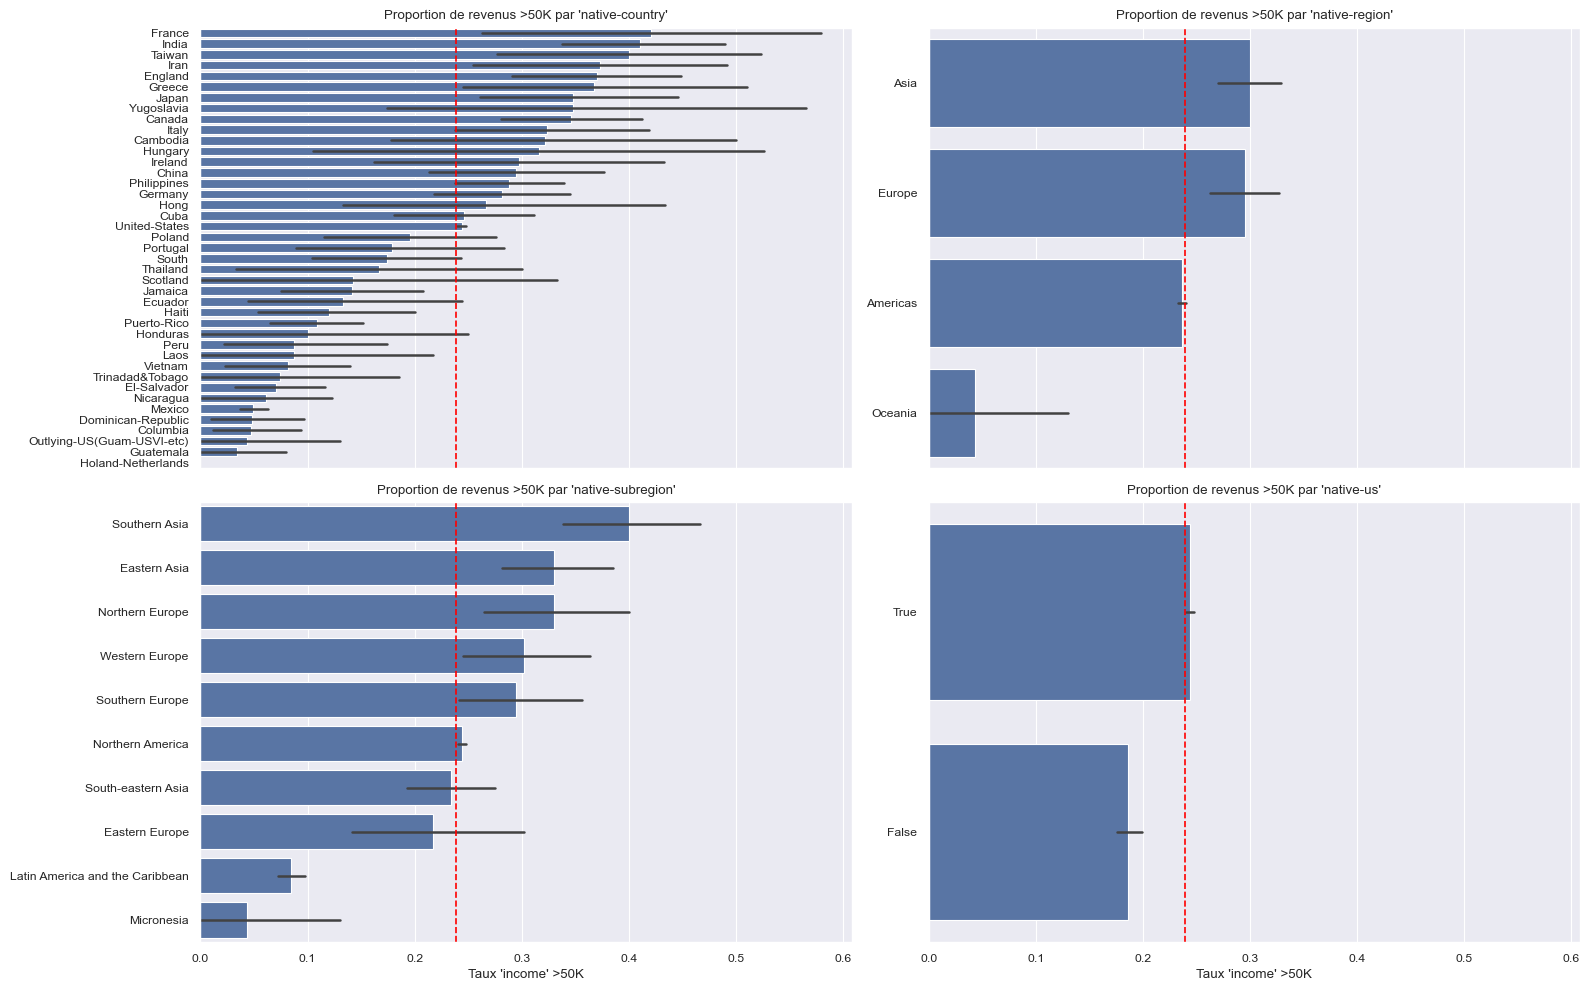

In [294]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

for ax, var in zip(axs.flatten(), geo_vars):
    df_temp = df.groupby(var)[target[0]].mean().sort_values(ascending=False)

    sns.barplot(data=df, x=target[0], y=var, order=df_temp.index, ax=ax)
    ax.axvline(df[target[0]].mean(), color='red', linestyle='--', label='moyenne globale')
    ax.set_title(f"Proportion de revenus >50K par '{var}'")
    ax.set_xlabel(f"Taux '{target[0]}' >50K")
    ax.set_ylabel('')

plt.tight_layout()
#plt.savefig(FIG_DIR / 'geo_discrimination.png', dpi=150, bbox_inches='tight')
plt.show()

On peut ainsi mieux comprendre pourquoi les variables `native-us` (0.0008) et `native-region` (0.0004) sont très faibles : elles cachent le fait que certains petits groupes d'immigrants (ex: France, Inde, Taiwan, Iran) ont statistiquement des taux de hauts revenus très élevés dans ce dataset, bien plus que la moyenne américaine. En les noyant dans des énormes régions ou dans un groupe "Non-USA", on perd ce signal.


On peut également voir, pour le découpage par pays, que les barres d'erreur sont immenses. En réalité, on as peu d'individus pour la plupart des pays, les taux de revenus >50K sont donc très variables et ce n'est pas fiable, il y a beaucoup d'information "bruitée".

L'utilisation de `native-subregion` permet de réduire ce problème tout en conservant les taux de hauts revenus pour certains groupes de migrants avec les pays de l'Asie de l'Est, du Sud et d'Europe. Les barres d'erreur sont beaucoup plus courtes que pour les pays individuels. Les estimations sont donc plus robustes.

In [297]:
for col in geo_vars:
    if (col != 'native-subregion'):
        remove_col(col)

Colonne 'native-country' supprimée.
Colonne 'native-region' supprimée.
Colonne 'native-us' supprimée.


Voici le jeu de données nettoyé :

In [298]:
df.info()

<class 'pandas.DataFrame'>
Index: 47985 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               47985 non-null  int64   
 1   workclass         47985 non-null  category
 2   education-num     47985 non-null  int64   
 3   marital-status    47985 non-null  category
 4   occupation        47985 non-null  category
 5   relationship      47985 non-null  category
 6   race              47985 non-null  category
 7   sex               47985 non-null  category
 8   capital-gain      47985 non-null  int64   
 9   capital-loss      47985 non-null  int64   
 10  hours-per-week    47985 non-null  int64   
 11  income            47985 non-null  int64   
 12  native-subregion  47985 non-null  category
dtypes: category(7), int64(6)
memory usage: 2.9 MB


In [299]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income,native-subregion
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0,Northern America
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0,Northern America
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0,Northern America
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0,Northern America
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0,Latin America and the Caribbean


## 3. Analyse exploratoire